In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dask
import scipy as sp

In [30]:
def normed_init_wave_fn(x,R,L,x_0=0,p_0=0): # Function returns normalized e^(-Rx^2), can also be modified to include other functions
    wf = np.array([[]],complex)  
    L_ch = 0                    # System size can be specified whenever required in the function
    for i in range(len(R)):
        curr_R = R[i]
        integral, error = sp.integrate.quad(lambda x:np.abs(np.exp(-curr_R*((x-x_0)**2)))**2,x[0],x[-1])
        wfval = np.array([np.exp(1j*p_0*x-curr_R*((x-x_0)**2))/(np.sqrt(integral))])
        wf = np.append(wf,wfval)
    
    wf = wf.reshape((len(R),-1))
    return wf

def plot_normed_wvfn(x,R,wfval):
    for i in range(len(R)):
        plt.plot(x,wfval[i,:],label=r'$R = {}$.'.format(R[i]))
    plt.title(r"Initial Wavefunction $\phi_{0}(x)$")
    plt.xlabel(r"$x \rightarrow$")
    plt.ylabel(r"$\phi_{0}(x) \rightarrow$")
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_first_derivative(x,R,fdr):
    for i in range(len(R)):
        plt.plot(x,fdr[i,:],label=r'$R = {}$.'.format(R[i]))
    plt.title(r"First Derivative $\phi_{0}^\prime(x)$")
    plt.xlabel(r"$x \rightarrow$")
    plt.ylabel(r"$\phi_{0}^\prime(x) \rightarrow$")
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_second_derivative(x,R,fdr):
    for i in range(len(R)):
        plt.plot(x,fdr[i,:],label=r'$R = {}$.'.format(R[i]))
    plt.title(r"Second Derivative $\phi_{0}^{\prime\prime}(x)$")
    plt.xlabel(r"$x \rightarrow$")
    plt.ylabel(r"$\phi_{0}^{\prime\prime}(x) \rightarrow$")
    plt.legend()
    plt.grid()
    plt.show()

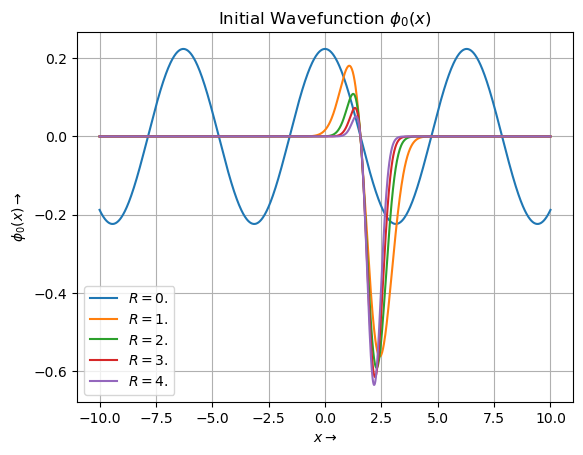

In [31]:
L = 10 # System size
N = 1000 # Number of discretizations
a = (2*L)/N # Discretized spacing distance
R = np.arange(5) # Variance is 1/(2R)
p_0 = 1 # initial momentum
x_0 = 2 # initial position (mean)
x_input = np.linspace(-L,L,N)
ini_wf = normed_init_wave_fn(x_input,R,L,x_0,p_0)
#print(ini_wf.shape)

plot_normed_wvfn(x_input,R,ini_wf)

In [32]:
def first_derivative(wfval,a): # Linear extrapolation at the boundary points
    fprime = np.zeros(wfval.shape,complex)
    for i in range(wfval.shape[0]):
        fprime[i,1:-1] = (wfval[i,2:] - wfval[i,:-2])/(2*a)
    
    fprime[:,0] = 2*fprime[:,1]-fprime[:,2]
    fprime[:,-1] = 2*fprime[:,-2]-fprime[:,-3]
    
    return fprime

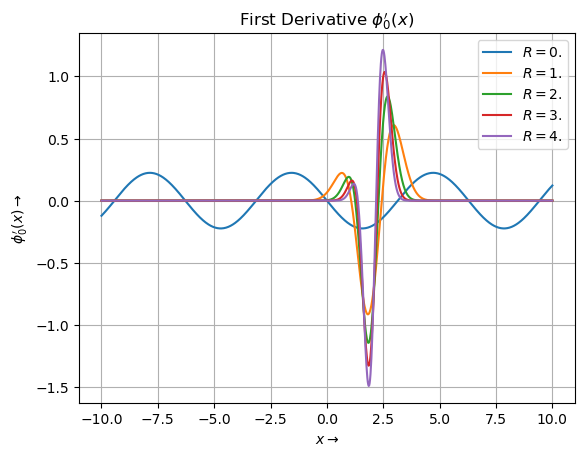

In [33]:
fdpr = first_derivative(ini_wf,a)

#print(fdpr)

plot_first_derivative(x_input,R,fdpr)


In [34]:
def second_derivative(wfval,a): # Linear extrapolation at the two boundary points
    fdprime = np.zeros(wfval.shape,complex)
    for i in range(wfval.shape[0]):
        fdprime[i,1:-1] = (wfval[i,:-2]+wfval[i,2:]-2*wfval[i,1:-1])/(a**2)
        
    fdprime[:,0] = 2*fdprime[:,1]-fdprime[:,2]
    fdprime[:,-1] = 2*fdprime[:,-2]-fdprime[:,-3]
    
    return fdprime

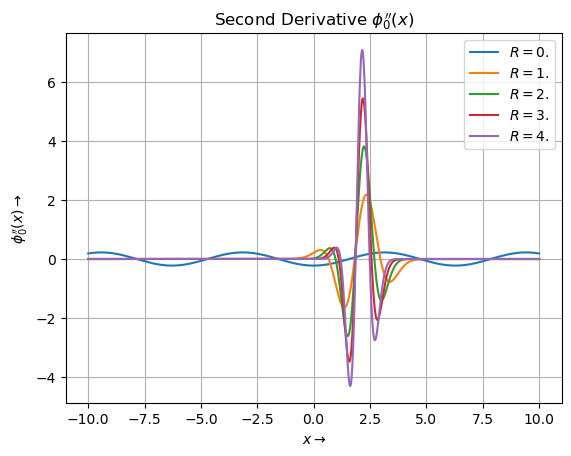

In [35]:
fdoubleprime = second_derivative(ini_wf,a)

plot_second_derivative(x_input,R,fdoubleprime)

In [23]:
def table_coeff(r):
    
    A = np.zeros((r,r))
    B = np.array([(k+1)**2 for k in range(r)])

    for i in range(r):
        A[:,i] = (B**(i+1))/(np.math.factorial(2*(i+1)))

    A = 2*A # Definition of A complete!

    b = np.zeros((r,(2*r)+1))

    for i in range(r):
        temp = np.zeros((2*r)+1)
        temp[r] = -2
        temp[r-i-1], temp[r+i+1] = 1, 1
        b[i,:] = temp

    # Definition of b complete!

    coeff = np.linalg.solve(A,b)
    
    
    return coeff[0][r:]

def table(r):
    
    r_max = np.max(r)
    
    if np.size(r)==1:
        return table_coeff(r)
    
    else:
        table = np.zeros((len(r),r_max+1))
        
        for j in range(np.size(r)):
            temp_coeff = table_coeff(r[j])
            table[j,:len(temp_coeff)] = temp_coeff
        return table

table_test = table([6,7])
print(table_test)        

[[-2.92394132e+00  1.66385446e+00 -2.36337610e-01  3.89013718e-02
  -4.72596711e-03  2.74851163e-04  3.55076291e-06  0.00000000e+00]
 [-2.50150035e+00  1.30529312e+00 -1.94457401e-02 -5.10870453e-02
   1.86005391e-02 -2.53645425e-03 -1.31864343e-04  5.76141128e-05]]


In [17]:
table_test = table([6,7])
print(table_test)

[[-2.92394132e+00  1.66385446e+00 -2.36337610e-01  3.89013718e-02
  -4.72596711e-03  2.74851163e-04  3.55076291e-06  0.00000000e+00]
 [-2.50150035e+00  1.30529312e+00 -1.94457401e-02 -5.10870453e-02
   1.86005391e-02 -2.53645425e-03 -1.31864343e-04  5.76141128e-05]]


In [10]:
# Solving the system using 3 point formula

T = 100 # Time range
N_t = 1000 # Time steps
delta_t = T/N_t

b = 1j*delta_t/(a**2)
mat_A = sp.sparse.diags([(-b/2)*np.ones(N-1),(1+b)*np.ones(N),(-b/2)*np.ones(N-1)],[-1,0,1]).toarray()

In [11]:
mult_mat = np.matmul(np.linalg.inv(mat_A),np.conjugate(mat_A))

In [25]:
test_wvfn = ini_wf[1,:] # R=1 testing
psi_t = np.zeros((N,N_t),complex)
psi_t[:,0] = test_wvfn

for i in range(1,N_t):
    psi_t[:,i] = np.dot(np.real(mult_mat),psi_t[:,i-1])+1j*np.dot(np.imag(mult_mat),psi_t[:,i-1])
    
    

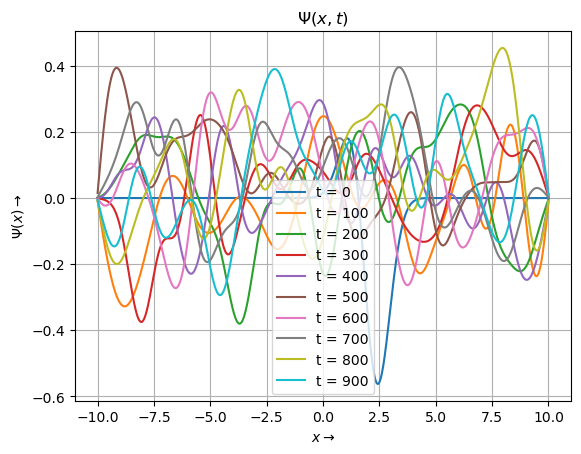

In [29]:
for i in range(0,1000,100):
    #plt.cla()
    plt.plot(x_input,psi_t[:,i],label=r"t = {}".format(i))
    #plt.savefig("psi{}.jpg".format(i))
    
plt.title(r"$\Psi(x,t)$")
plt.xlabel(r"$x \rightarrow$")
plt.ylabel(r"$\Psi(x) \rightarrow$")
plt.legend()
plt.grid()
plt.show()    

In [ ]:
import cv2
import glob

frameSize = (500, 500)

out = cv2.VideoWriter('output_video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 60, frameSize)

for filename in glob.glob('C:/Users/Computing/Documents/PYL800/*.jpg'):
    img = cv2.imread(filename)
    out.write(img)

out.release()